# Test Target Model

In [1]:
from datasets import dataset_list
import pandas as pd
import joblib
import gpplot
import seaborn as sns

from model_predictions import (deepspcas9_predictions,
                               rule_set2_predictions,
                               vbc_predictions,
                               crispron_predictions)

import target_featurization as ft
from core import (setup_plots,
                  get_model_correlations,
                  get_model_rank_loss,
                  point_range_plot,
                  get_feature_df)

In [2]:
setup_plots()

## Import Data

In [3]:
nt_model = joblib.load('../models/RuleSet3.pkl')
target_model = joblib.load('../models/target_model.pkl')
target_model_lite = joblib.load('../models/target_lite_model.pkl')
seq_target_model = joblib.load('../models/seq_target_model.pkl')
train_data_names = pd.read_csv('../data/processed/train_data_names.csv').name.to_list()
protein_domains = pd.read_csv('../data/interim/protein_domains.csv')
aa_seqs = pd.read_csv('../data/interim/aa_seqs.csv')

Trying to unpickle estimator SimpleImputer from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator Pipeline from version 1.0.dev0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [4]:
dataset_activity_list = []
for ds in dataset_list:
    if ds.endogenous:
        ds.load_data()
        ds.set_sgrnas()
        dataset_activity = ds.get_sg_df(include_group=True, include_activity=True)
        dataset_activity['dataset'] = ds.name
        dataset_activity['genomewide'] = ds.genomewide
        dataset_activity['tracr'] = ds.tracr
        design_df = ds.get_designs()
        dataset_activity = dataset_activity.merge(design_df, how='inner',
                                                  on=['sgRNA Sequence', 'sgRNA Context Sequence', 'PAM Sequence'])
        dataset_activity_list.append(dataset_activity)
dataset_activity_df = (pd.concat(dataset_activity_list)
                       .reset_index(drop=True))
dataset_activity_df = ft.add_target_columns(dataset_activity_df)  # only necessary for getting transcript bases
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,tracr,Input,Quota,...,On-Target Rank,Off-Target Rank,On-Target Rank Weight,Off-Target Rank Weight,Combined Rank,Pick Order,Picking Round,Picking Notes,AA Index,Transcript Base
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,-1.139819,Aguirre2016,True,Hsu2013,ENSG00000111605,MAX,...,140,76,1.0,1.0,96,48.0,2.0,Previously skipped due to: Spacing Violation: ...,123,ENST00000435070
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,-0.793055,Aguirre2016,True,Hsu2013,ENSG00000165480,MAX,...,58,29,1.0,1.0,37,23.0,2.0,Previously skipped due to: Spacing Violation: ...,258,ENST00000314759
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.946453,Aguirre2016,True,Hsu2013,ENSG00000021776,MAX,...,179,115,1.0,1.0,88,235.0,3.0,Previously skipped due to: Outside Target Wind...,56,ENST00000156471
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,-0.429590,Aguirre2016,True,Hsu2013,ENSG00000117174,MAX,...,149,62,1.0,1.0,119,74.0,2.0,Previously skipped due to: Spacing Violation: ...,291,ENST00000370574
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.734196,Aguirre2016,True,Hsu2013,ENSG00000204574,MAX,...,71,3,1.0,1.0,5,2.0,1.0,None,80,ENST00000326195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54409,TTTGTTCTTTAAATGGCTAC,CAAATTTGTTCTTTAAATGGCTACAGGAGG,AGG,MED12,-1.951933,Munoz2016,False,Chen2013,ENSG00000184634,MAX,...,707,67,1.0,1.0,346,217.0,2.0,Previously skipped due to: Spacing Violation: ...,983,ENST00000374080
54410,TTTGTTCTTTCTGTGCGCAC,AGATTTTGTTCTTTCTGTGCGCACTGGTGA,TGG,PTPN11,-1.693789,Munoz2016,False,Chen2013,ENSG00000179295,MAX,...,148,11,1.0,1.0,67,35.0,2.0,Previously skipped due to: Spacing Violation: ...,152,ENST00000351677
54411,TTTGTTGAGGCTCCTGGCTG,AAGATTTGTTGAGGCTCCTGGCTGTGGCGA,TGG,RPTOR,-1.234981,Munoz2016,False,Chen2013,ENSG00000141564,MAX,...,528,549,1.0,1.0,614,350.0,2.0,Previously skipped due to: Spacing Violation: ...,732,ENST00000306801
54412,TTTGTTGCCAATAGTTGGCC,TCTTTTTGTTGCCAATAGTTGGCCTGGCAA,TGG,SKP2,-0.871017,Munoz2016,False,Chen2013,ENSG00000145604,MAX,...,114,168,1.0,1.0,159,154.0,4.0,Previously skipped due to: Outside Target Wind...,399,ENST00000274255


In [5]:
test_set = dataset_activity_df[dataset_activity_df['dataset'].isin(['Aguirre2016',
                                                                    'Behan2019', 'Koike-Yusa2014',
                                                                    'Shalem2014'])]
test_set['sgRNA Sequence'].nunique()

23605

In [6]:
transcript_bases = list(dataset_activity_df['Transcript Base']
                        .unique())
conservation_df = (pd.read_parquet('../data/interim/conservation.parquet',
                                   filters=[[('Transcript Base', 'in', transcript_bases)]])
                   .reset_index(drop=True))

## Get Predictions

### External Models

In [7]:
model_prediction_list = [deepspcas9_predictions,
                         rule_set2_predictions,
                         vbc_predictions,
                         crispron_predictions]
for model_prediction in model_prediction_list:
    model_prediction.load_model_predictions()
    model_prediction.set_sgrnas()
    if model_prediction.target_col is None:
        dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                        how='left',
                                                        on=['sgRNA Sequence',
                                                            'sgRNA Context Sequence',
                                                            'PAM Sequence'])
    else:
        dataset_activity_df = dataset_activity_df.merge(model_prediction.prediction_df,
                                                        how='left',
                                                        left_on=['sgRNA Sequence',
                                                                 'sgRNA Context Sequence',
                                                                 'PAM Sequence',
                                                                 'sgRNA Target'],
                                                        right_on=['sgRNA Sequence',
                                                                  'sgRNA Context Sequence',
                                                                  'PAM Sequence',
                                                                  model_prediction.target_col])
    dataset_activity_df[model_prediction.name + ' train'] = (dataset_activity_df['sgRNA Sequence']
                                                             .isin(model_prediction.sgrnas))
dataset_activity_df

,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,tracr,Input,Quota,...,Rule Set 2,Rule Set 2 train,gene,VBC score,VBC Activity,VBC Bioscore,genome,VBC score train,CRISPRon,CRISPRon train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,-1.139819,Aguirre2016,True,Hsu2013,ENSG00000111605,MAX,...,0.489201,False,CPSF6,0.621,0.436,0.695,hg38,False,13.88,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,-0.793055,Aguirre2016,True,Hsu2013,ENSG00000165480,MAX,...,0.464962,False,SKA3,0.486,0.320,0.465,hg38,False,3.39,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.946453,Aguirre2016,True,Hsu2013,ENSG00000021776,MAX,...,0.525786,False,AQR,0.665,0.551,0.613,hg38,False,27.21,False
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,-0.429590,Aguirre2016,True,Hsu2013,ENSG00000117174,MAX,...,0.369761,False,ZNHIT6,0.549,0.358,0.580,hg38,False,14.67,False
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.734196,Aguirre2016,True,Hsu2013,ENSG00000204574,MAX,...,0.604568,False,ABCF1,0.592,0.657,0.428,hg38,False,44.40,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56357,TTTGTTCTTTAAATGGCTAC,CAAATTTGTTCTTTAAATGGCTACAGGAGG,AGG,MED12,-1.951933,Munoz2016,False,Chen2013,ENSG00000184634,MAX,...,0.443932,True,MED12,0.545,0.282,0.627,hg38,True,6.76,True
56358,TTTGTTCTTTCTGTGCGCAC,AGATTTTGTTCTTTCTGTGCGCACTGGTGA,TGG,PTPN11,-1.693789,Munoz2016,False,Chen2013,ENSG00000179295,MAX,...,0.442974,False,PTPN11,0.576,0.350,0.665,hg38,True,11.66,False
56359,TTTGTTGAGGCTCCTGGCTG,AAGATTTGTTGAGGCTCCTGGCTGTGGCGA,TGG,RPTOR,-1.234981,Munoz2016,False,Chen2013,ENSG00000141564,MAX,...,0.441318,False,RPTOR,0.535,0.433,0.494,hg38,True,46.54,False
56360,TTTGTTGCCAATAGTTGGCC,TCTTTTTGTTGCCAATAGTTGGCCTGGCAA,TGG,SKP2,-0.871017,Munoz2016,False,Chen2013,ENSG00000145604,MAX,...,0.456960,False,SKP2,0.501,0.328,0.488,hg38,True,17.97,False


In [8]:
model_prediction_names = [m.name for m in model_prediction_list]
dataset_activity_df[model_prediction_names].isna().sum()

DeepSpCas9       0
Rule Set 2       0
VBC score     4957
CRISPRon         0
dtype: int64

### Rule Set 3

In [9]:
train_data_list = list()
for ds in dataset_list:
    if ds.name in train_data_names:
        train_data_list.append(ds)

train_data_sgs = set()
for ds in train_data_list:
    ds.load_data()
    ds.set_sgrnas()
    train_data_sgs |= set(ds.sgrnas)

X = get_feature_df(dataset_activity_df)
dataset_activity_df['Rule Set 3 (sequence)'] = nt_model.predict(X)
dataset_activity_df['Rule Set 3 (sequence) train'] = dataset_activity_df['sgRNA Sequence'].isin(train_data_sgs)
dataset_activity_df

100%|██████████| 56362/56362 [02:25<00:00, 387.64it/s]


,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Target,sgRNA Activity,dataset,genomewide,tracr,Input,Quota,...,gene,VBC score,VBC Activity,VBC Bioscore,genome,VBC score train,CRISPRon,CRISPRon train,Rule Set 3 (sequence),Rule Set 3 (sequence) train
0,AAAAAACTTACCCCTTTGAC,AAAAAAAAAACTTACCCCTTTGACTGGCCA,TGG,CPSF6,-1.139819,Aguirre2016,True,Hsu2013,ENSG00000111605,MAX,...,CPSF6,0.621,0.436,0.695,hg38,False,13.88,False,-0.995147,False
1,AAAAACATTATCATTGAGCC,TGGCAAAAACATTATCATTGAGCCTGGATT,TGG,SKA3,-0.793055,Aguirre2016,True,Hsu2013,ENSG00000165480,MAX,...,SKA3,0.486,0.320,0.465,hg38,False,3.39,False,-1.474522,False
2,AAAAAGAGATTGTCAAATCA,TATGAAAAAGAGATTGTCAAATCAAGGTAG,AGG,AQR,0.946453,Aguirre2016,True,Hsu2013,ENSG00000021776,MAX,...,AQR,0.665,0.551,0.613,hg38,False,27.21,False,-0.096036,False
3,AAAAAGCATCTCTAGAAATA,TTCAAAAAAGCATCTCTAGAAATATGGTCC,TGG,ZNHIT6,-0.429590,Aguirre2016,True,Hsu2013,ENSG00000117174,MAX,...,ZNHIT6,0.549,0.358,0.580,hg38,False,14.67,False,-0.648340,False
4,AAAAAGCGAGATACCCGAAA,AAAAAAAAAGCGAGATACCCGAAAAGGCAG,AGG,ABCF1,0.734196,Aguirre2016,True,Hsu2013,ENSG00000204574,MAX,...,ABCF1,0.592,0.657,0.428,hg38,False,44.40,False,-0.141700,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56357,TTTGTTCTTTAAATGGCTAC,CAAATTTGTTCTTTAAATGGCTACAGGAGG,AGG,MED12,-1.951933,Munoz2016,False,Chen2013,ENSG00000184634,MAX,...,MED12,0.545,0.282,0.627,hg38,True,6.76,True,-1.467062,True
56358,TTTGTTCTTTCTGTGCGCAC,AGATTTTGTTCTTTCTGTGCGCACTGGTGA,TGG,PTPN11,-1.693789,Munoz2016,False,Chen2013,ENSG00000179295,MAX,...,PTPN11,0.576,0.350,0.665,hg38,True,11.66,False,-1.701230,True
56359,TTTGTTGAGGCTCCTGGCTG,AAGATTTGTTGAGGCTCCTGGCTGTGGCGA,TGG,RPTOR,-1.234981,Munoz2016,False,Chen2013,ENSG00000141564,MAX,...,RPTOR,0.535,0.433,0.494,hg38,True,46.54,False,-0.478020,True
56360,TTTGTTGCCAATAGTTGGCC,TCTTTTTGTTGCCAATAGTTGGCCTGGCAA,TGG,SKP2,-0.871017,Munoz2016,False,Chen2013,ENSG00000145604,MAX,...,SKP2,0.501,0.328,0.488,hg38,True,17.97,False,-1.028439,True


### Rule Set 3 Target

In [10]:
target_cols = ['sgRNA Sequence', 'sgRNA Context Sequence',
               'Orientation', 'Target Cut %', 'Target Cut Length',
               'Target Transcript']  # Note don't need Transcript Base and AA Index
unique_activity = dataset_activity_df[target_cols].drop_duplicates()
target_feature_df, target_feature_cols = ft.build_target_feature_df(unique_activity,
                                                                    features=['position', 'aa',
                                                                              'domain', 'conservation'],
                                                                    aa_seq_df=aa_seqs,
                                                                    protein_domain_df=protein_domains,
                                                                    conservation_df=conservation_df,
                                                                    id_cols=['sgRNA Context Sequence', 'Target Cut Length',
                                                                             'Target Transcript', 'Orientation'])
X_target = target_feature_df[target_feature_cols]
unique_activity['Target Score'] = target_model.predict(X_target)


In [11]:
id_cols = ['sgRNA Context Sequence', 'Target Cut Length', 'Target Transcript', 'Orientation']
target_score_export = unique_activity[id_cols + ['Target Score']]
target_score_export.to_csv('../data/interim/target_score_export.csv',
                           index=False)

In [12]:
target_feat_export = pd.concat([unique_activity[id_cols].reset_index(drop=True),
                                X_target.reset_index(drop=True)], axis=1)
target_feat_export.to_csv('../data/interim/target_feat_export.csv', index=False)

In [13]:
target_lite_feature_df, target_lite_feature_cols = ft.build_target_feature_df(unique_activity,
                                                                    features=['position', 'aa'],
                                                                    aa_seq_df=aa_seqs,
                                                                    protein_domain_df=protein_domains,
                                                                    conservation_df=conservation_df,
                                                                    id_cols=['sgRNA Context Sequence', 'Target Cut Length',
                                                                             'Target Transcript', 'Orientation'])
X_target_lite = target_lite_feature_df[target_lite_feature_cols]
unique_activity['Target Lite Score'] = target_model_lite.predict(X_target_lite)

In [14]:
target_lite_score_export = unique_activity[id_cols + ['Target Lite Score']]
target_lite_score_export.to_csv('../data/interim/target_lite_score_export.csv',
                                index=False)


In [15]:
target_lite_feat_export = pd.concat([unique_activity[id_cols].reset_index(drop=True),
                                     X_target_lite.reset_index(drop=True)], axis=1)
target_lite_feat_export.to_csv('../data/interim/target_lite_feat_export.csv', index=False)


### Rule Set 3 Seq Target

In [16]:
seq_target_cols = ['sgRNA Context Sequence', 'Orientation',
                   'Target Cut Length', 'Target Transcript']
seq_targ_df = (X.add_suffix(' (seq)')
              .reset_index()
              .drop_duplicates()
              .merge(target_feature_df[seq_target_cols + target_feature_cols]
                     .add_suffix(' (targ)')
                     .rename({x + ' (targ)': x for x in seq_target_cols}, axis=1),
                     on='sgRNA Context Sequence',
                     how='left')
               .reset_index(drop=True))

In [17]:
seq_targ_X = seq_targ_df.drop(seq_target_cols, axis=1)
seq_targ_scores = seq_targ_df[seq_target_cols].reset_index(drop=True)
seq_targ_scores['Rule Set 3 (seq/targ)'] = seq_target_model.predict(seq_targ_X)

### Updating score matrix

In [18]:
dataset_activity_df = (dataset_activity_df.merge(unique_activity, how='left',
                                                 on=target_cols)
                       .merge(seq_targ_scores, how='left',
                              on=seq_target_cols))
dataset_activity_df['Rule Set 3 (sequence + target)'] = (dataset_activity_df['Rule Set 3 (sequence)'] +
                                            dataset_activity_df['Target Score'])
dataset_activity_df['Rule Set 3 (sequence + target) train'] = dataset_activity_df['Rule Set 3 (sequence) train']
dataset_activity_df['Rule Set 3 (sequence + target lite)'] = (dataset_activity_df['Rule Set 3 (sequence)'] +
                                                              dataset_activity_df['Target Lite Score'])
dataset_activity_df['Rule Set 3 (sequence + target lite) train'] = dataset_activity_df['Rule Set 3 (sequence) train']
dataset_activity_df['Rule Set 3 (seq/targ) train'] = dataset_activity_df['Rule Set 3 (sequence) train']

### Performance

In [19]:
score_cols = (['Rule Set 3 (sequence)', 'Rule Set 3 (sequence + target)', 'Rule Set 3 (sequence + target lite)',
               'Rule Set 3 (seq/targ)'] +
              model_prediction_names)
guide_train_cols = [name + ' train' for name in score_cols]
filtered_predictions = dataset_activity_df[~dataset_activity_df[guide_train_cols].any(axis=1)].copy()
long_predictions = (filtered_predictions.melt(id_vars=['sgRNA Sequence', 'sgRNA Context Sequence',
                                                       'PAM Sequence', 'sgRNA Activity',
                                                       'sgRNA Target', 'dataset', 'genomewide'],
                                              value_vars=score_cols,
                                              var_name='model',
                                              value_name='prediction')
                    .dropna())

In [20]:
cor_performance_ci = get_model_correlations(long_predictions)

100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s]


In [21]:
# hamronize dataset names

unique_dataset_names = (cor_performance_ci.groupby('dataset')
                        .agg({'size': 'max'})
                        .reset_index())
unique_dataset_names['dataset_name'] = (unique_dataset_names['dataset'] +
                                        '\n(n = ' +
                                        unique_dataset_names['size'].astype(int).astype(str) +
                                        ')')
cor_performance_ci = (cor_performance_ci.drop('dataset_name', axis=1)
                      .merge(unique_dataset_names.drop('size', axis=1),
                             how='inner', on='dataset'))


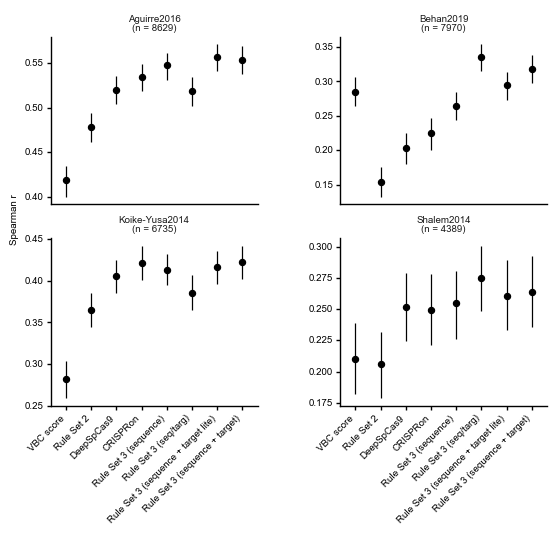

<ggplot: (8766709602853)>

In [22]:
g = point_range_plot(cor_performance_ci, 'model', 'spearman',
                     'spearman_025', 'spearman_975', xlabel='',
                     ylabel='Spearman r', wspace=0.4, facet='dataset_name')
#g.save('../figures/target_rs3_performance.pdf', width=3, height=2.3)
g

In [ ]:
spread_cor_performance = (cor_performance_ci
                          .pivot_table(values='spearman',
                                       index='dataset',
                                       columns='model'))
(spread_cor_performance['Rule Set 3 (sequence + target)'] -
 spread_cor_performance['Rule Set 3 (sequence)']).mean()

In [ ]:
point_range_plot(cor_performance_ci, 'model', 'pearson',
                 'pearson_025', 'pearson_975', xlabel='',
                 ylabel='Pearson r')

In [ ]:
genomewide_predictions = long_predictions[long_predictions.genomewide].copy()
rank_loss_performance_ci = get_model_rank_loss(genomewide_predictions)

In [ ]:
g = point_range_plot(rank_loss_performance_ci, 'model', 'avg_abs_rank_diff',
                     'avg_abs_rank_diff_025', 'avg_abs_rank_diff_975', xlabel='',
                     ylabel='Avg. Absolute Rank Loss', wspace=0.4)
g

## Comparison With Bioscore

In [ ]:
def scatter_density(data, x, y, **kwargs):
    gpplot.point_densityplot(data[[x, y]].dropna(), x, y, **kwargs)
    gpplot.add_correlation(data[[x, y]].dropna(), x, y)

g = sns.FacetGrid(data=filtered_predictions,
                  col='dataset', aspect=1, height=2)
g.map_dataframe(scatter_density, x='Target Score', y='VBC Bioscore',
                s=10)
g.set_xlabels('Target Score')
g.set_ylabels('VBC Bioscore')
g.set_titles(col_template='{col_name}')
gpplot.savefig('../figures/target_model_bioscore_comparison.pdf', dpi=300)